# Clustering Analysis
We will use the features extracted from the last convolution layer of a "ResNet18" deep learning architecture as image representation for this clustering assignment using "forward hook" in [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html) OR `feature_extraction` in [Torch Vision](https://pytorch.org/vision/stable/feature_extraction.html). 

The labels will be used as ground truths for performance evaluation when we use external performance measure.

You will use the following clustering methods:
- K-means
- Spectral Clustering
- Hierarchical Clustering
- DBSCAN
- Bisecting K-means

## 1. Feature Extraction
- Resize each cropped image to a 224 × 224 pixel image.
- Normalize the resized image dataset.
- Extract features for each image from the last convolution layer of "ResNet18"

In [1]:
import os
import random
import glob
from pathlib import Path
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from IPython.display import display

%matplotlib inline

In [2]:
dog_classes_assigned = set([
    'Cocker Spaniel',
    'Rhodesian Ridgeback',
    'Staffordshire Bullterrier',
    'Standard Schnauzer'
])

dog_images_path = "./dataset/Images/"
dog_annots_path = "./dataset/Annotation/"
dog_classes = os.listdir(dog_images_path)

In [3]:
# The functions and code in this cell are taken exactly from assignment 1 where I preprocessed the assigned dog classes
# by getting the bounding-box information and cropping them.

# DISCLAIMER: Again, the functions below are copied (and slightly modified) from the Kaggle Notebook provided on Canvas.

def get_files(dog_class, img_path=dog_images_path, annot_path=dog_annots_path, images=True, annots=False):
    if images:
        dir_path = os.path.join(img_path, dog_class)
    if annots:
        dir_path = os.path.join(annot_path, dog_class)
        
    if os.path.exists(dir_path):
        temp_files = os.listdir(dir_path)
        files = [os.path.join(dir_path, file) for file in temp_files]
        return files
    else:
        print(f"Directory {dir_path} does not exist.")
        return []
    
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

def crop_and_resize_image(image_path, bounding_boxes, output_dir, size=(224, 224)):
    with Image.open(image_path) as im:
        for idx, bbox in enumerate(bounding_boxes):
            cropped_img = im.crop(bbox)
            resized_img = cropped_img.resize(size, Image.LANCZOS)
            resized_img = resized_img.convert('RGB')

            # create a separate directory (named "Cropped") for cropped and resized images
            new_path = image_path.replace('Images/', f'./{output_dir}/')
            new_path = new_path.replace('.jpg', f'-{idx}.jpg')
            
            # create the directory if it doesn't exist
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)

            resized_img.save(new_path)
            
def get_image(annot):
    """Get image path from annotation path"""
    file_path, filename = os.path.split(annot)
    img_folder = os.path.basename(file_path)
    img_filename = os.path.join(dog_images_path, img_folder, f"{filename}.jpg")
    return img_filename

def process_images(image_paths, annot_paths, output_dir):
    """Process a list of images and their corresponding annotation files."""
    for img_path, annot_path in zip(image_paths, annot_paths):
        bounding_boxes = get_bounding_boxes(annot_path)
        crop_and_resize_image(img_path, bounding_boxes, output_dir)

In [4]:
mapping = {}

for i, name in enumerate(dog_classes):
    mapping[f"class{i+1}"] = name

c1_images = get_files(mapping['class1'])
c2_images = get_files(mapping['class2'])
c3_images = get_files(mapping['class3'])
c4_images = get_files(mapping['class4'])

c1_annots = get_files(mapping['class1'], images=False, annots=True)
c2_annots = get_files(mapping['class2'], images=False, annots=True)
c3_annots = get_files(mapping['class3'], images=False, annots=True)
c4_annots = get_files(mapping['class4'], images=False, annots=True)

In [5]:
dog_images = c1_images + c2_images + c3_images + c4_images
annots = c1_annots + c2_annots + c3_annots + c4_annots

In [6]:
cropped_dir = 'Cropped'
cropped_path = os.path.join('./dataset', cropped_dir)

In [7]:
# after running this line, we shoud have the cropped and resized images saved in Cropped/

# image_paths = [get_image(annot) for annot in annots]
# process_images(image_paths, annots, cropped_dir)

In [8]:
c1_images = get_files(mapping['class1'], img_path=cropped_path)
c2_images = get_files(mapping['class2'], img_path=cropped_path)
c3_images = get_files(mapping['class3'], img_path=cropped_path)
c4_images = get_files(mapping['class4'], img_path=cropped_path)

In [9]:
images = c1_images + c2_images + c3_images + c4_images
images = np.array(images)

In [10]:
# assigning labels to use for external validation in clustering
c1_labels = [0] * len(c1_images)
c2_labels = [1] * len(c2_images)
c3_labels = [2] * len(c3_images)
c4_labels = [3] * len(c4_images)

In [11]:
image_labels = c1_labels + c2_labels + c3_labels + c4_labels
image_labels = np.array(image_labels)

### Normalizing Image Dataset

In [12]:
def load_and_normalize_images(image_paths):
    normalized_images = []
    for path in image_paths:
        path = path.replace('\\', os.sep)
        img = cv2.imread(path)
        img = img / 255.0
        normalized_images.append(img)
    return normalized_images

In [13]:
normalized_images = load_and_normalize_images(images)

In [15]:
len(normalized_images)

697

### Extracting Features
Extract image features using the last convolution layer of "ResNet18". The source code is based on this [reference](https://kozodoi.me/blog/20210527/extracting-features).

In [16]:
import torch
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [17]:
def extract_features_resnet18(images):
    
    # load the pre-trained ResNet18 model with the new 'weights' parameter
    # Source: https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    model.eval()

    # remove the last layer to get features from the last convolution layer
    model = torch.nn.Sequential(*(list(model.children())[:-1]))

    # define a transform to convert to tensor and normalize for ResNet18
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # custom dataset class
    class CustomDataset(Dataset):
        def __init__(self, images, transform):
            self.images = images
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img = self.images[idx]
            img = self.transform(img)
            return img.float()  # ensure the image is FloatTensor

    # create a dataset and a data loader
    dataset = CustomDataset(images, transform)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # extract features
    features = []
    with torch.no_grad():
        for imgs in data_loader:
            output = model(imgs)
            output = output.view(output.size(0), -1)  # flatten the features
            features.extend(output.cpu().numpy())

    return features

In [18]:
features = extract_features_resnet18(normalized_images)

In [19]:
len(features)

697

In [16]:
print(features[0].shape)

(512,)


## 2. Dimensionality Reduction
Perform dimension reduction on your new dog image representation dataset to reduce the dimension to 2.

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=2)
reduced_features  = pca.fit_transform(features)

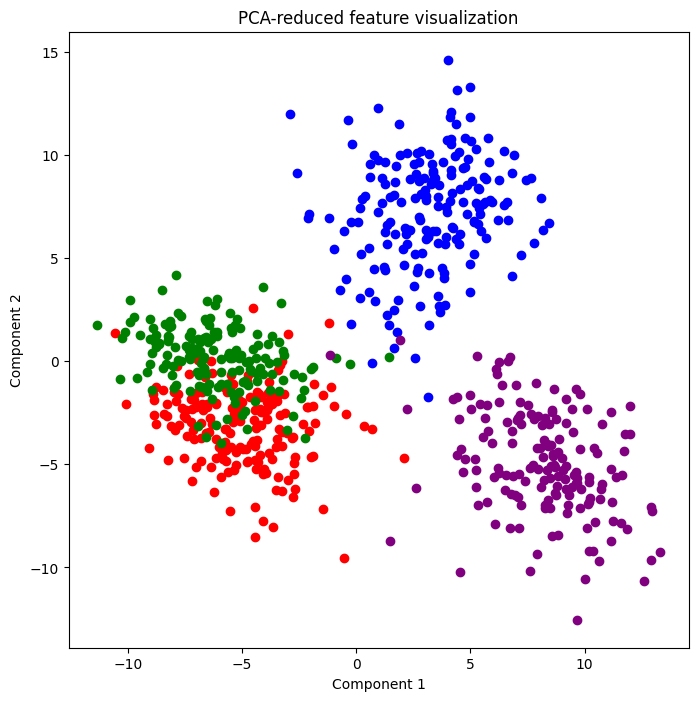

In [23]:
colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(8, 8))

for i in range(4):
    class_indices = np.flatnonzero(image_labels == i)
    plt.scatter(reduced_features[class_indices, 0], reduced_features[class_indices, 1], color=colors[i])

plt.title("PCA-reduced feature visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## 3. Clustering Algorithm
Perform clustering using the following approaches on the 2D dataset you preprocessed:

- **K-Mean clustering and its variants with $k=4$**
    - KMeans clustering: (Use KMeans with `init = 'Random'`)
    - KMeans with `init = k-means++`
    - Bisecting Kmeans with `init = 'Random'`
    - Spectral Clustering with default parameters.
<hr>

- **DBSCAN**
    - What are the `eps` and `min_samples` parameter values you used to get 4 clusters?
<hr>

- **Agglomerative Clustering with number of clusters set to 4**
    - Single link $MIN$
    - Complete link $MAX$
    - Group Average
    - Ward's Method

In [24]:
from sklearn.cluster import KMeans

kmeans_random = KMeans(n_clusters=4, init='random', n_init='auto', random_state=42)
clusters_kmeans_random = kmeans_random.fit_predict(reduced_features)

In [25]:
kmeans_plus = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=42)
clusters_kmeans_plus = kmeans_plus.fit_predict(reduced_features)

In [26]:
# SOURCE: This function is taken from my github account
def plot_clusters(features, clusters, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster')
    plt.show()

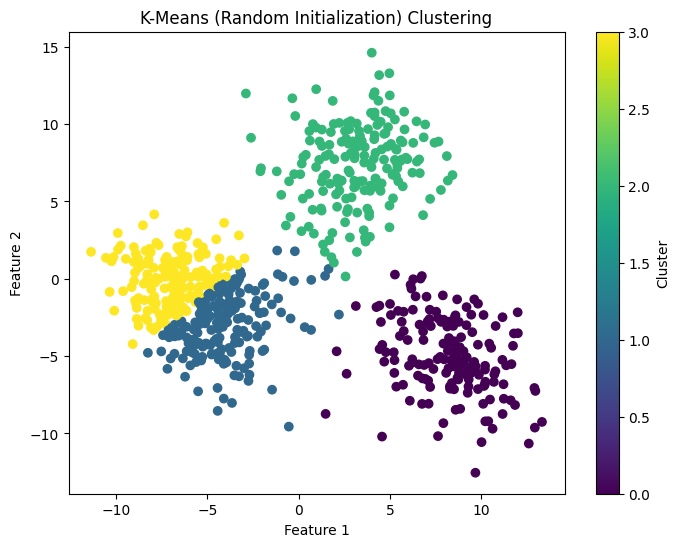

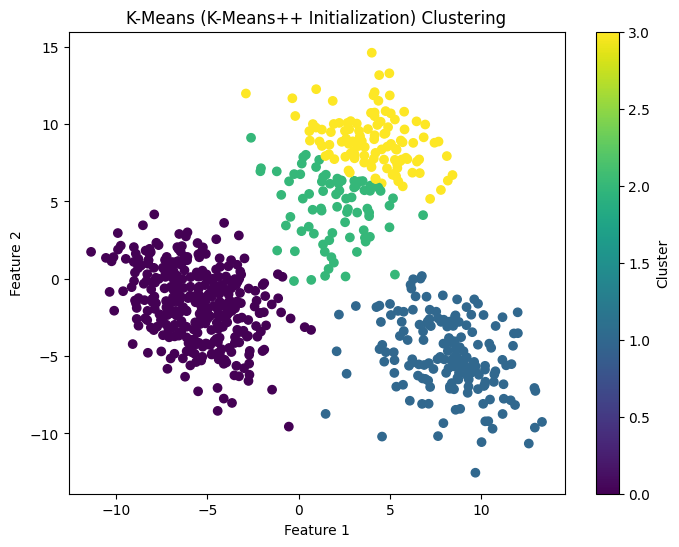

In [27]:
plot_clusters(reduced_features, clusters_kmeans_random, "K-Means (Random Initialization) Clustering")
plot_clusters(reduced_features, clusters_kmeans_plus, "K-Means (K-Means++ Initialization) Clustering")

In [28]:
from sklearn.cluster import BisectingKMeans

bisect_means = BisectingKMeans(n_clusters=4, init='random', random_state=0)
clusters_bisect = bisect_means.fit_predict(reduced_features)

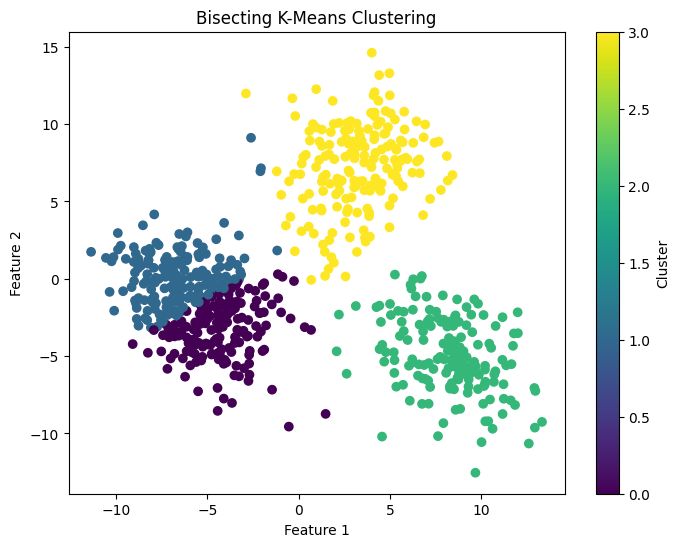

In [29]:
plot_clusters(reduced_features, clusters_bisect, "Bisecting K-Means Clustering")

In [30]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=4, random_state=42)
clusters_spectral = spectral.fit_predict(reduced_features)

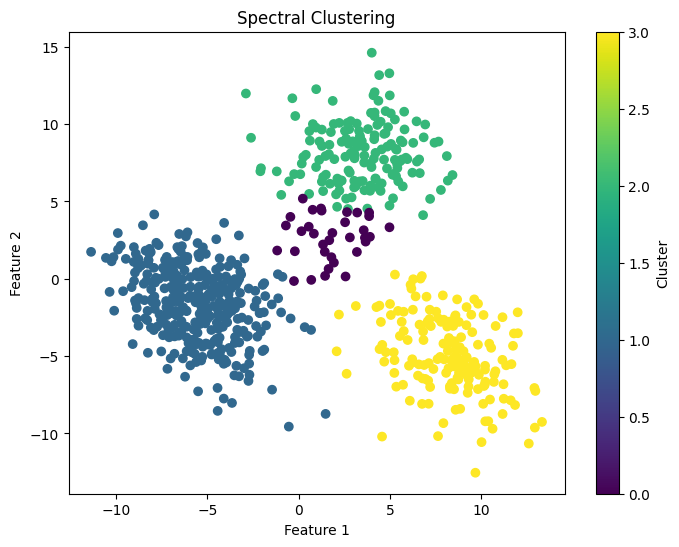

In [31]:
plot_clusters(reduced_features, clusters_spectral, "Spectral Clustering")

In [32]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.90, min_samples=10)
clusters_dbscan = dbscan.fit_predict(reduced_features)

# number of clusters
n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)

print("Estimated number of clusters: %d" % n_clusters)

Estimated number of clusters: 4


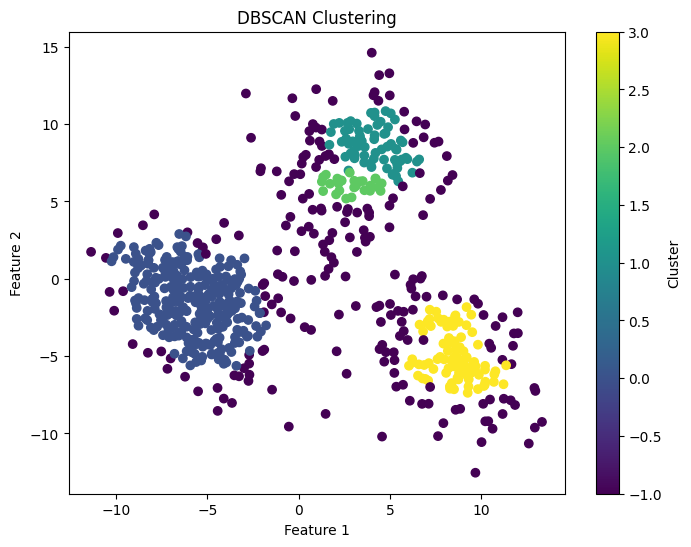

In [33]:
plot_clusters(reduced_features, clusters_dbscan, "DBSCAN Clustering")

I tried various combinations of $\epsilon$ and $\text{min_samples}$, however, since there are 3 visible clusters, DBSCAN struggled to find $k=4$ clusters; one of the combinations that worked above is:
- $\epsilon = 0.90$
- $\text{min_samples} = 10$

In [34]:
from sklearn.cluster import AgglomerativeClustering

agg_single = AgglomerativeClustering(n_clusters=4, linkage='single')
clusters_agg_single = agg_single.fit_predict(reduced_features)

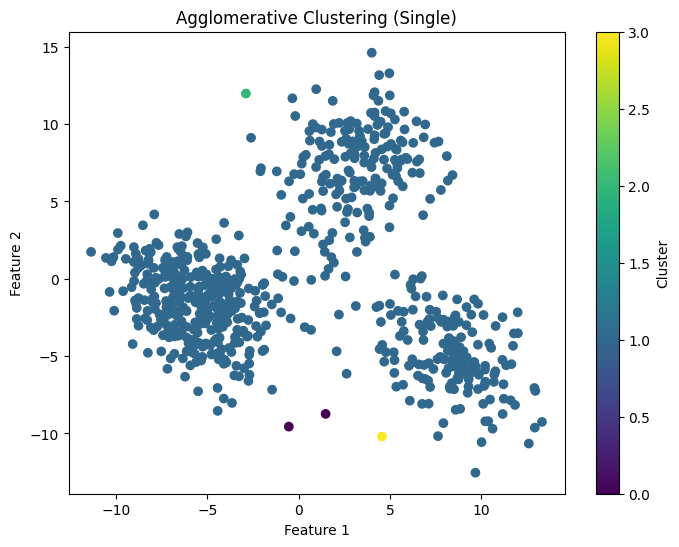

In [35]:
plot_clusters(reduced_features, clusters_agg_single, "Agglomerative Clustering (Single)")

In [36]:
agg_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
clusters_agg_complete = agg_complete.fit_predict(reduced_features)

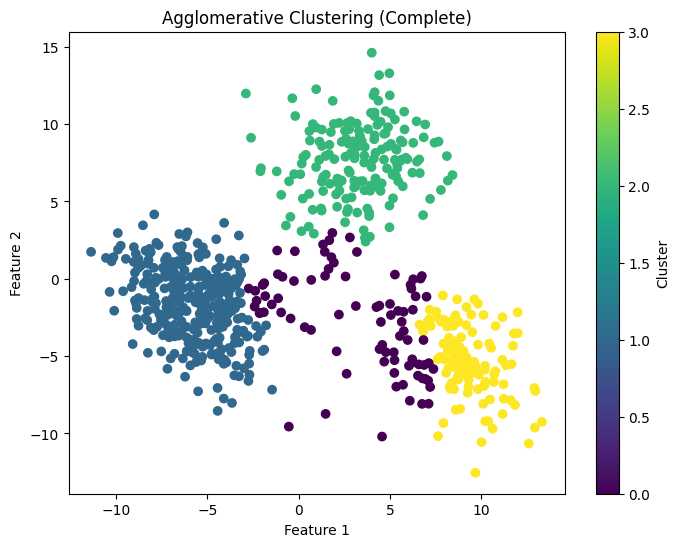

In [37]:
plot_clusters(reduced_features, clusters_agg_complete, "Agglomerative Clustering (Complete)")

In [38]:
agg_average = AgglomerativeClustering(n_clusters=4, linkage='average')
clusters_agg_average = agg_average.fit_predict(reduced_features)

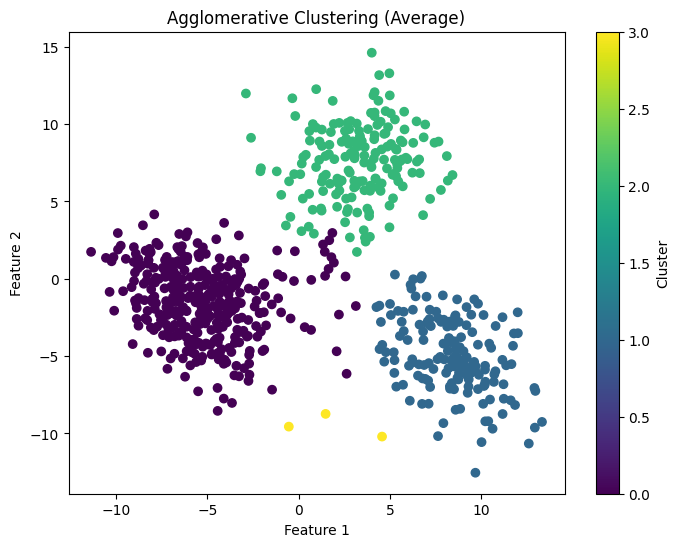

In [39]:
plot_clusters(reduced_features, clusters_agg_average, "Agglomerative Clustering (Average)")

In [40]:
agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
clusters_agg_ward = agg_ward.fit_predict(reduced_features)

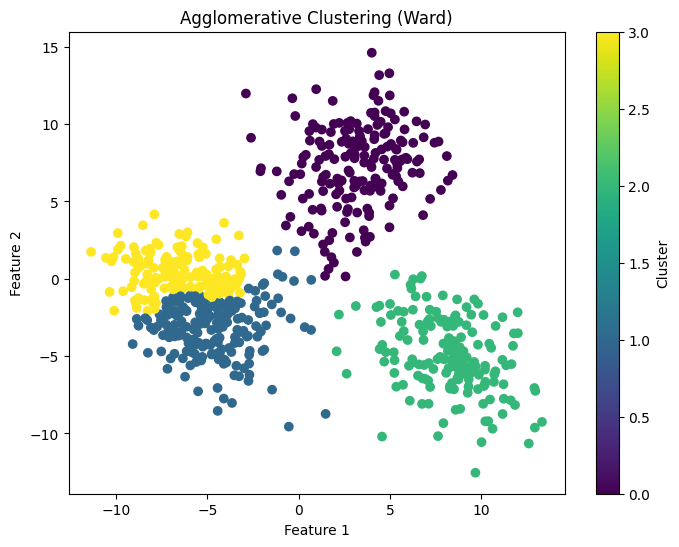

In [41]:
plot_clusters(reduced_features, clusters_agg_ward, "Agglomerative Clustering (Ward)")

## 4. Clustering Evaluations

- Perform clustering performance evaluation using `Fowlkes-Mallows index`. Compute the Fowlkes-Mallows index for each method on the 2D dataset.
- Perform clustering performance evaluation using `Silhouette Coefficient` Compute the Silhouette Coefficient for each method.
- Rank the methods from the best to the worst for our dataset based on Fowlkes-Mallows index.
- Rank the methods from the best to the worst for our dataset based on Silhouette Coefficient.

In [42]:
from sklearn.metrics import fowlkes_mallows_score

fm_kmeans_random = fowlkes_mallows_score(image_labels, clusters_kmeans_random)
fm_kmeans_plus = fowlkes_mallows_score(image_labels, clusters_kmeans_plus)
fm_bisecting_kmeans = fowlkes_mallows_score(image_labels, clusters_bisect)
fm_spectral = fowlkes_mallows_score(image_labels, clusters_spectral)
fm_dbscan = fowlkes_mallows_score(image_labels, clusters_dbscan)
fm_agg_single = fowlkes_mallows_score(image_labels, clusters_agg_single)
fm_agg_complete = fowlkes_mallows_score(image_labels, clusters_agg_complete)
fm_agg_average = fowlkes_mallows_score(image_labels, clusters_agg_average)
fm_agg_ward = fowlkes_mallows_score(image_labels, clusters_agg_ward)

In [43]:
from sklearn.metrics import silhouette_score

sc_kmeans_random = silhouette_score(reduced_features, clusters_kmeans_random)
sc_kmeans_plus = silhouette_score(reduced_features, clusters_kmeans_plus)
sc_bisecting_kmeans = silhouette_score(reduced_features, clusters_bisect)
sc_spectral = silhouette_score(reduced_features, clusters_spectral)
sc_dbscan = silhouette_score(reduced_features, clusters_dbscan)
sc_agg_single = silhouette_score(reduced_features, clusters_agg_single)
sc_agg_complete = silhouette_score(reduced_features, clusters_agg_complete)
sc_agg_average = silhouette_score(reduced_features, clusters_agg_average)
sc_agg_ward = silhouette_score(reduced_features, clusters_agg_ward)

In [44]:
fm_scores = {
    'KMeans Random': fm_kmeans_random,
    'KMeans Plus': fm_kmeans_plus,
    'Spectral Clustering': fm_spectral,
    'DBSCAN': fm_dbscan,
    'Agglomerative Single': fm_agg_single,
    'Agglomerative Complete': fm_agg_complete,
    'Agglomerative Average': fm_agg_average,
    'Agglomerative Ward': fm_agg_ward
}

fm_ranked = sorted(fm_scores.items(), key=lambda x: x[1], reverse=True)

In [45]:
sc_scores = {
    'KMeans Random': sc_kmeans_random,
    'KMeans Plus': sc_kmeans_plus,
    'Spectral Clustering': sc_spectral,
    'DBSCAN': sc_dbscan,
    'Agglomerative Single': sc_agg_single,
    'Agglomerative Complete': sc_agg_complete,
    'Agglomerative Average': sc_agg_average,
    'Agglomerative Ward': sc_agg_ward
}

sc_ranked = sorted(sc_scores.items(), key=lambda x: x[1], reverse=True)

In [46]:
fm_ranked

[('Agglomerative Ward', 0.8341796173485009),
 ('KMeans Random', 0.7841940430856945),
 ('Agglomerative Average', 0.7710904345773508),
 ('Spectral Clustering', 0.7603805664304122),
 ('KMeans Plus', 0.726096624622517),
 ('Agglomerative Complete', 0.7171582482414972),
 ('DBSCAN', 0.5354163335738317),
 ('Agglomerative Single', 0.49712303039747635)]

In [47]:
sc_ranked

[('Agglomerative Average', 0.5715588482287359),
 ('KMeans Plus', 0.5451296219512194),
 ('Agglomerative Complete', 0.521460982270634),
 ('Spectral Clustering', 0.5056611721634632),
 ('KMeans Random', 0.5019041224842857),
 ('Agglomerative Ward', 0.48675264606453644),
 ('DBSCAN', 0.2704346026740957),
 ('Agglomerative Single', -0.12091649113069879)]